# Evaluate Effect of Coordinate Accuracy
How accurately can we predict energies without knowing the equilibrium structure?

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from schnetpack.md import AtomsConverter
from jcesr_ml.schnetpack import load_model, run_model
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm_notebook as tqdm
from ase.io.xyz import read_xyz
from ase.units import Hartree, eV
from io import StringIO
from glob import glob
import pandas as pd
import numpy as np
import torch
import json
import os
import re

Get the SchNet Directory

In [2]:
schnet_dir = os.path.join('..', 'benchmark', 'schnet')

## Load in the Data
Get the data with the real and approximate atomic coordinates

In [3]:
test_data = pd.read_pickle('test_data.pkl.gz')

In [4]:
with open(os.path.join(schnet_dir, 'baseline-stats.json')) as fp:
    baseline_stats = json.load(fp)

## Compare the Performance for the `g4mp2-transfer` Model
Using the `g4mp2-transfer` model as a baseline as it was the model that performed the best on the benchmark test

In [5]:
model = load_model('g4mp2-transfer', 117232, arch_dir=schnet_dir, weights_dir=schnet_dir)

In [6]:
test_data['pred'] = run_model(model, test_data, 'xyz')

In [7]:
test_data['pred_gen'] = run_model(model, test_data, 'xyz_gen')

In [8]:
test_data['pred_relaxed'] = run_model(model, test_data, 'xyz_relaxed')

In [9]:
test_data['pred_searched'] = run_model(model, test_data, 'xyz_searched')

Evaluate the Differences in Errors

In [10]:
for col in test_data.columns:
    if col.startswith('pred'):
        print('{} MAE: {:.5f} eV'.format(col, 
                                         np.abs(test_data[col] - test_data['g4mp2_0k']).mean() * Hartree / eV))
print('MAD: {:.5f} eV'.format(baseline_stats['u0_mad']))

pred MAE: 0.01340 eV
pred_gen MAE: 0.45983 eV
pred_relaxed MAE: 0.34972 eV
pred_searched MAE: 0.32688 eV
MAD: 841.18497 eV


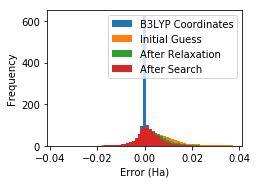

In [11]:
fig, ax = plt.subplots()

# Get the largest error
max_error = np.percentile(np.abs(test_data['pred_gen'] - test_data['g4mp2_0k']), 95)
bins = np.linspace(-max_error, max_error, 64)

ax.hist((test_data['pred'] - test_data['g4mp2_0k']).tolist(), bins=bins, label='B3LYP Coordinates', density=True)
ax.hist((test_data['pred_gen'] - test_data['g4mp2_0k']).tolist(), bins=bins, label='Initial Guess', density=True)
ax.hist((test_data['pred_relaxed'] - test_data['g4mp2_0k']).tolist(), bins=bins, label='After Relaxation', density=True)
ax.hist((test_data['pred_searched'] - test_data['g4mp2_0k']).tolist(), bins=bins, label='After Search', density=True)

ax.legend()

ax.set_xlabel('Error (Ha)')
ax.set_ylabel('Frequency')

fig.set_size_inches(3.5, 2.5)

*Finding*: Predictive accuracy degrades by about an order of magnitude when we do not use the actual coordinates, but is still _well below_ the MAD of the dataset. Using the coordinates after the rotor search seems to work the best.

## Assessing Impact of Guessed Coordinates on G4MP2 Models
We are going to test the G4MP2 model, G4MP2 $\Delta$-learning, and G4MP2 stacked models.

In [12]:
for model in ['g4mp2', 'g4mp2-delta', 'g4mp2-stacked-delta', 'g4mp2-transfer']:
    g4mp2_model = load_model(model, 117232, arch_dir=schnet_dir, weights_dir=schnet_dir)
    test_data['{}_pred'.format(model)] = run_model(g4mp2_model, test_data, 'xyz', ['u0'])
    test_data['{}_pred_searched'.format(model)] = run_model(g4mp2_model, test_data, 'xyz_searched', ['u0'])

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                             | 7590/13026 [05:12<04:15, 21.29it/s]

In [13]:
for col in test_data.columns:
    if re.match('g4mp2.*_pred.*', col):
        print('{} MAE: {:.5f} eV'.format(col, 
                                         np.abs(test_data[col] - test_data['g4mp2_0k']).mean() * Hartree / eV))
print('Baseline: {:.5f} eV'.format(baseline_stats['u0_atomization_mae']))

g4mp2_pred MAE: 0.01492 eV
g4mp2_pred_searched MAE: 0.34907 eV
g4mp2-delta_pred MAE: 0.00445 eV
g4mp2-delta_pred_searched MAE: 0.02987 eV
g4mp2-stacked-delta_pred MAE: 0.01484 eV
g4mp2-stacked-delta_pred_searched MAE: 0.33945 eV
g4mp2-transfer_pred MAE: 0.01340 eV
g4mp2-transfer_pred_searched MAE: 0.32688 eV
Baseline: 0.20059 eV


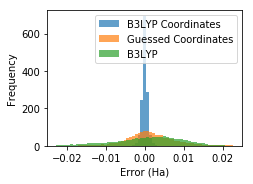

In [14]:
fig, ax = plt.subplots()

# Get the largest error
max_error = np.percentile(np.abs(test_data['g4mp2_pred_searched'] - test_data['g4mp2_0k']), 95)
bins = np.linspace(-max_error, max_error, 64)

ax.hist((test_data['g4mp2-stacked-delta_pred'] - test_data['g4mp2_0k']).tolist(), bins=bins,
        label='B3LYP Coordinates', density=True, alpha=0.7)
ax.hist((test_data['g4mp2_pred_searched'] - test_data['g4mp2_0k']).tolist(), bins=bins,
        label='Guessed Coordinates', density=True, alpha=0.7)
ax.hist((test_data['u0_atom'] - test_data['g4mp2_atom']).tolist(), bins=bins, label='B3LYP', 
        density=True, alpha=0.7)

ax.legend()

ax.set_xlabel('Error (Ha)')
ax.set_ylabel('Frequency')

fig.set_size_inches(3.5, 2.5)

*Finding*: The G4MP2 model does perform better than B3LYP when given the B3LYP coordinates, but has an error 4x higher when guessed coordinates are used.

## Evaluate Effect of Re-Training
We have retrained the `u0` models using the OpenBabel coordinates (searched) with various levels of perturbation. Here, we see if that has any effect on the model errors.

In [15]:
rattle_sizes = os.listdir(os.path.join('networks', 'g4mp2-transfer', 'no-conformers'))

In [16]:
conformers = ['conformers', 'no-conformers', 'relaxed-conformers']

In [17]:
for c in conformers:
    for r in rattle_sizes:
        if os.path.exists(os.path.join('networks', 'g4mp2-transfer', c, r)):
            model = load_model('g4mp2-transfer', c, r, arch_dir=schnet_dir)
            test_data['pred_searched_r{}-{}'.format(r, c)] = run_model(model, test_data, 'xyz_searched')

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 8814/13026 [06:16<03:50, 18.28it/s]

Compute the MAEs

In [18]:
rattle_results = pd.DataFrame([{
    'rattle': float(r),
    'conformers': c,
    'mae': mean_absolute_error(test_data['g4mp2_0k'], test_data['pred_searched_r{}-{}'.format(r, c)]) * Hartree / eV
} for r in rattle_sizes for c in conformers if 'pred_searched_r{}-{}'.format(r, c) in test_data.columns])

In [19]:
rattle_results

,conformers,mae,rattle
0,conformers,0.848502,10.000
1,no-conformers,0.945556,10.000
2,conformers,0.727316,1.000
3,no-conformers,0.744707,1.000
4,conformers,0.240722,0.300
5,no-conformers,0.235645,0.300
6,relaxed-conformers,0.233028,0.300
7,conformers,0.214001,0.010
8,no-conformers,0.214685,0.010
9,relaxed-conformers,0.211126,0.010


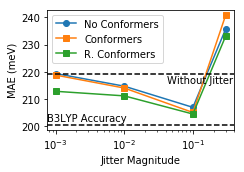

In [20]:
fig, ax = plt.subplots()

max_rattle = 0.5

# Add in the rattled results
non_zero = rattle_results.query('rattle > 0 and conformers == "no-conformers" and rattle < {}'.format(max_rattle)).sort_values('rattle')
ax.semilogx(non_zero['rattle'], non_zero['mae'] * 1000, 'o-', label='No Conformers')

non_zero = rattle_results.query('rattle > 0 and conformers == "conformers" and rattle < {}'.format(max_rattle)).sort_values('rattle')
ax.semilogx(non_zero['rattle'], non_zero['mae'] * 1000, 's-', label='Conformers')

non_zero = rattle_results.query('rattle > 0 and conformers == "relaxed-conformers" and rattle < {}'.format(max_rattle)).sort_values('rattle')
ax.semilogx(non_zero['rattle'], non_zero['mae'] * 1000, 's-', label='R. Conformers')

# Add in the baselines
ax.set_xlim(ax.get_xlim())

# B3LYP
val = baseline_stats['u0_atomization_mae'] * 1000
ax.plot(ax.get_xlim(), [val]*2 , 'k--')
ax.text(min(ax.get_xlim()) * 1.01, val + 0.5, 'B3LYP Accuracy', ha='left', va='bottom')

# Retraining
#val = mean_absolute_error(test_data['pred_searched'], test_data['g4mp2_0k']) * Hartree / eV * 1000
#ax.plot(ax.get_xlim(), [val]*2 , 'k--')
#ax.text(min(ax.get_xlim()) * 1.01, val + 0.5, 'Retraining', ha='left', va='bottom')

#  Without jitter
val = mean_absolute_error(test_data['pred_searched_r0.0000-conformers'], test_data['g4mp2_0k']) * Hartree / eV * 1000
ax.plot(ax.get_xlim(), [val]*2, 'k--')
ax.text(max(ax.get_xlim()) * 0.96, val - 0.5, 'Without Jitter', ha='right', va='top')


# Make it pretty
ax.set_ylabel('MAE (meV)')
ax.set_xlabel('Jitter Magnitude')
ax.legend()

fig.set_size_inches(3.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'jitter-retraining.png'), dpi=320)

*Finding*: Training on the coordinates has a benefit and rattling does allow for minor improvements in the accuracy. So far, it does not seem like conformers helps anything

## Save Predictions
They take a long time to generate, so I'm saving them to disk to run analyses in a different notebook.

In [21]:
test_data.to_csv('test-results.csv.gz', index=False, compression='gzip')